In [9]:
import numpy as np
import gym
from gym import spaces
import random
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
# Dicionário do deck (apenas usado para visualização se quiser e não internamente)
dict_deck = {
    14: '4p',  # 4 de paus (Zap)
    13: '7c',  # 7 de copas (Copeta)
    12: 'Ae',  # Ás de espadas (Espadilha)
    11: '7o',  # 7 de ouros (Ourito)
    10: '3',
    9: '2',
    8: 'A',
    7: 'K',
    6: 'J',
    5: 'Q',
    4: '7',
    3: '6',
    2: '5',
    1: '4',
    0: 'Carta indisponível'
}

In [5]:
"""
TODO: Deixar no ambiente quem comeca jogando, alternando conforme quem ganhou a última
TODO: Arrumar bgl da acao 0
TODO: Inicializar HandWinner
TODO: env.reset
"""

class TrucoMineiroEnv(gym.Env):
  def __init__(self):
    # Cria o deck
    self.deck =  self._create_deck()
    # Contador de mãos jogadas
    self.turn = 0
    # Aleatoriza quem começa (0=oponente, 1=agente)
    self.first_player = random.randint(0, 1)
    # Definindo o espaço de ação (0, 1, 2 representam as cartas na mão do agente)
    self.action_space = spaces.Discrete(3)
    # Definindo o espaço de observação (carta jogada pelo oponente, cartas na mão do agente, estado da primeira mão)
    self.observation_space = spaces.Tuple((
      spaces.Discrete(15),  # Carta jogada pelo oponente, 0 se for a vez do agente
      spaces.MultiDiscrete([15]*3),  # Cartas na mão do agente (0 representa carta jogada)
      spaces.Discrete(4)  # Estado da primeira mão (0 - essa é a primeira mão, 1 - oponente ganhou, 2 - empate, 3 - agente ganhou)
    ))
    # Variáveis de estado
    self.opponent_card = 0 if self.first_player == 1 else self.draw() # Carta jogada pelo oponente (nenhuma ou aleatório)
    self.agent_cards = np.sort([self.draw(), self.draw(), self.draw()])[::-1]
    # Agente compra 3 cartas
    self.first_hand_winner = 0  # Estado da primeira mão

  def _create_deck(self):
    # Deck de cartas com 4p=14 > 7c=13 > Ae=12 > 7o=11 > 3=10 > 2=9 > A=8 > K=7 > J=6 > Q=5 > 7=4 > 6=3 > 5=2 > 4=1
    # 1 de cada manilha, 3 cartas A, 3 cartas 4, 2 cartas 7 e as 4 das demais
    return 1*[14] + 1*[13] + 1*[12] + 1*[11] + 4*[10] + 4*[9] + 3*[8] + 4*[7] + 4*[6] + 4*[5] + 2*[4] + 4*[3] + 4*[2] + 3*[1]

  def draw(self):
    # Compra uma carta do deck
    if self.deck:
      card_index = random.randint(0, len(self.deck) - 1)
      card = self.deck.pop(card_index)
      return card
    else:
      return None

  def step(self, action):
    # Verifica se a ação é válida (0, 1 ou 2)
    if action not in [0, 1, 2]:
      raise ValueError("Invalid action. Action must be 0, 1, or 2.")

    # Executa a ação (joga uma carta)
    player_card = self.agent_cards[action]
    self.agent_cards[action] = 0  # Marca a carta como jogada

    # Se não tiver ação do oponente, joga uma carta aleatória para ele
    if self.opponent_card == 0:
      self.opponent_card = self.draw()

    # Se alguém não jogou, levanta erros (não é para acontecer)
    if self.opponent_card == 0:
      raise ValueError("Opponent has no card set.")
    if player_card == 0:
      raise ValueError("Player has no card set.")
    
    # Determina o vencedor da mão
    hand_winner = self._determine_hand_winner(self.opponent_card, player_card)

    # Determina o vencedor da rodada, se existir
    round_winner = self._determine_round_winner(hand_winner)

    # Determina quem ganhou a primeira mão se estiver nela
    if self.turn == 0:
      self.first_hand_winner = hand_winner

    # Define quem começa jogando a próxima mão (mantém em caso de empate, senão quem ganhou começa a próxima)
    if hand_winner != 2:
      self.first_player = min(hand_winner - 1, 1)

    # Se o oponente começar, ele joga uma carta aleatória, senão ele começa sem carta
    if self.first_player == 0:
      self.opponent_card = self.draw()
    else:
      self.opponent_card = 0

    # Avança o turno
    self.turn += 1

    # Determina a recompensa (0 para empates ou rodada inacabada, +1 vitória, -1 derrota)
    reward = 0 if round_winner == 0 else round_winner - 2

    # Sort na mão do agente
    self.agent_cards = np.sort(self.agent_cards)[::-1]

    # Retorna a observação, a recompensa (-1, 0 ou 1) se a rodada acabou ou 0 se a rodada não acabou e a flag de rodada acabada
    return (self.opponent_card, self.agent_cards, self.first_hand_winner), reward, round_winner != 0

  def reset(self):
    # Reseta o ambiente
    self.deck = self._create_deck()
    self.turn = 0
    self.first_player = random.randint(0, 1)
    self.opponent_card = 0 if self.first_player == 1 else self.draw()
    self.agent_cards = np.sort([self.draw(), self.draw(), self.draw()])[::-1]
    self.first_hand_winner = 0
    return self.opponent_card, self.agent_cards, self.first_hand_winner

  def _determine_hand_winner(self, opponent_card, agent_card):
    # Lógica para determinar o vencedor de uma mão (1=oponente ganha 2=empate 3=agente ganha)
    if agent_card > opponent_card:
      return 3
    if agent_card < opponent_card:
      return 1
    return 2

  def _determine_round_winner(self, hand_winner):
    # Lógica para determinar o vencedor de uma rodada (0=indeterminado 1=oponente ganha 2=empate 3=agente ganha)
    if self.turn == 2 or self.first_hand_winner == 2: # Terceiro turno ou primeira mão empatou
      return hand_winner
    if self.first_hand_winner == 1 and hand_winner != 3: # Oponente ganha primeira mão
      return 1
    if self.first_hand_winner == 3 and hand_winner != 1: # Agente ganha primeira mão
      return 3
    return 0 # Default

In [31]:
# Testes no ambiente
truco = TrucoMineiroEnv()
observation = truco.reset()
done = False
while not done:
    print(f"Observação (opponent_card, agent_cards[], first_hand_winner): {observation}")
    print(f"Cartas do agente: {[dict_deck[card_value] for card_value in truco.agent_cards]}")
    if dict_deck[truco.opponent_card] == 'Carta indisponível':
        print(f"Carta do oponente: ele joga depois")
    else:
        print(f"Carta do oponente: {dict_deck[truco.opponent_card]}")
    while True:
        action = random.randint(0, 2)  # Escolhe uma ação aleatória (trocar pelo agente)
        if truco.agent_cards[action] != 0:
            break
    print(f"Carta jogada pelo agente: {dict_deck[truco.agent_cards[action]]}")
    observation, reward, done = truco.step(action)

    print(f"Recompensa: {reward}\n")

Observação (opponent_card, agent_cards[], first_hand_winner): (9, array([8, 8, 2]), 0)
Cartas do agente: ['A', 'A', '5']
Carta do oponente: 2
Carta jogada pelo agente: A
Recompensa: 0

Observação (opponent_card, agent_cards[], first_hand_winner): (3, array([8, 2, 0]), 1)
Cartas do agente: ['A', '5', 'Carta indisponível']
Carta do oponente: 6
Carta jogada pelo agente: A
Recompensa: 0

Observação (opponent_card, agent_cards[], first_hand_winner): (0, array([2, 0, 0]), 1)
Cartas do agente: ['5', 'Carta indisponível', 'Carta indisponível']
Carta do oponente: ele joga depois
Carta jogada pelo agente: 5
Recompensa: -1



# Sarsa

In [19]:
"""
state: [c1, c2, c3] -> cards in the agents hand
        c4 -> card in the table
        w -> who won the first round
compress the state as single integer -> 
suppose that instead of 3 cards, it represents 3 coordinates in 3d space,
we can ravel it as a integer, helping a bit with coding
considering: 
4p -> 0; 7c -> 1; Ae -> 2; 7o -> 3; 3 -> 4; 2 -> 5; A -> 6 ...
4 -> 13
w is -1 if agent lost first round, 0 if draw/undecided, 1 if won

action: c -> card to be played
c = 0, 1 or 2, corresponding to the index of the card to be played

i will be considering that env.step returns a done variable, that is True
when the episode is over

TODO:
adopt convention: always sort the list of player cards, to avoid
repeating states !! ex: [11, 10, 3] is the same as [3, 11, 10]
also, leaving 0 always at the end of the list is required, and helps a lot
Fazer bater com o ambiente, rodar quantidade alta de episodios, analisar grafico/winrate
"""

class SarsaAgent:
    def __init__(self, eps: float, alpha: float, gamma: float, env) -> None:
        self.eps = eps
        self.alpha = alpha
        self.gamma = gamma
        self.env = env
        self.state_action_shape = (14, 14, 14, 14, 3, 3)
        # dictionary to store Q values
        self.Q = {}

    def _convert_state_action(self, state: list[int], action: int) -> int:
        state.sort(reverse=True)
        state_action = [idx for idx in state]
        state_action.append(action)
        state_action[4] += 1 # converts the -1 to 0, so that we can use it here
        return np.ravel_multi_index(state_action, self.state_action_shape)
    
    def _choose_greedy_action(self, state: list[int]) -> int:
        action = 0
        # add possible action if the card isnt 0, and it is the first 3 cards in the list
        possible_actions = [i for i, idx in enumerate(state) if idx != 0 and i < 3]
        # perform exploration
        if np.random.uniform(0, 1) < self.eps:
            return np.random.choice(possible_actions)
        # perfom exploitation
        else:
            Q_values = []
            for action in possible_actions:
                compressed = self._convert_state_action(state, action)
                # get the Q value, or return 0 if it doesnt have value yet
                Q_values.append(self.Q.get(compressed, 0))
            return np.argmax(Q_values)

    def run(self, n_episodes: int) -> None:
        reward = 0
        for _ in range(n_episodes):
            # obtain starting states and action
            state_1 = self.env.reset()
            action_1 = self._choose_greedy_action(state_1)
            # loops through the episode
            while True:
                # get next state, reward and next action
                state_2, reward, done = self.env.step(action_1)
                action_2 = self._choose_greedy_action(state_2)

                sa1_compressed = self._convert_state_action(state_1, action_1)
                sa2_compressed = self._convert_state_action(state_2, action_2)

                q1 = self.Q.get(sa1_compressed, 0)
                q2 = self.Q.get(sa2_compressed, 0)
                # updates the Q value
                self.Q[sa1_compressed] = q1 + self.alpha * (reward + self.gamma*q2 - q1)

                state_1 = state_2
                action_1 = action_2

                if done:
                    break

In [22]:
agent = SarsaAgent(0.1, 1)
agent._convert_state_action([11, 10, 2, 4, -1], 0)
agent.Q[289584] = 3
select_action = [agent._choose_greedy_action([11, 10, 2, 4, -1]) for _ in range(10)]
select_action

[0, 2, 1, 0, 0, 0, 0, 0, 0, 0]

# Q-Learning

In [ ]:
class QLearningAgent:
  def __init__(self, eps, alpha, gamma, env):
    self.eps = eps
    self.alpha = alpha
    self.gamma = gamma
    self.env = env
    self.Q_values = {}

  def _format_state(self, state):
    return (tuple(sorted(state[0])), state[1], state[2])

  def _choose_greedy_action(self, state):
    if np.random.uniform(0, 1) < self.eps:
      action = np.random.choice(range(len(self.Q_values[state])))
    else:
      action = np.argmax(self.Q_values[state])
    return action

  def _add_state(self, state):
    if state not in self.Q_values.keys():
      self.Q_values[state] = [0 for a in [0, 1, 2] if state[0][a] != 0]

  def train(self, num_episodes):
    for _ in range(num_episodes):
      state = self.env.reset()
      state = self._format_state(state)
      self._add_state(state)
      while True:
        action = self._choose_greedy_action(state)
        next_state, reward, done = self.env.step(action)
        next_state = self._format_state(next_state)
        self._add_state(next_state)
        self.Q_values[state][action] += self.alpha * (reward + self.gamma * max(self.Q_values[next_state]) - self.Q_values[state][action])
        state = next_state
        if done:
          break

# MonteCarlo

In [13]:
"""
TODO: Adicionar comentários
"""

from typing import Union

class MonteCarloAgent:
    def __init__(self, epsilon: float, gamma: float, env, on_policy: bool = True) -> None:
        self.epsilon = epsilon
        self.gamma = gamma
        self.env = env
        self.on_policy = on_policy
        self.total_actions = env.action_space.n
        self.action_values = {}
        self.stats = {}

    def _convert_state_format(self, state: tuple[int, list[int, int, int], int]) -> tuple[int, int, int, int, int]:
        return (state[0],) + tuple(state[1].tolist()) + (state[2],)
    
    def _add_state_action_pair(self, state: tuple[int, int, int, int, int], action: int) -> None:
        if (state, action) not in self.action_values.keys():
            self.action_values[(state, action)] = 0

    def _choose_action(self, state: tuple[int, int, int, int, int], explore: bool) -> int:
        possible_actions = [idx-1 for idx in range(1,4) if state[idx] != 0]
        if explore and np.random.random() < self.epsilon:
            return np.random.choice(possible_actions)
        max_value = float('-inf')
        for action in possible_actions:
            if (state, action) not in self.action_values.keys():
                self.action_values[(state, action)] = 0
            if self.action_values[(state, action)] > max_value:
                max_value = self.action_values[(state, action)]
                greedy_actions = [action]
            elif self.action_values[(state, action)] == max_value:
                greedy_actions.append(action)
        return np.random.choice(greedy_actions)
    
    def _generate_episode(self) -> list[list[Union[tuple[int, int], int, int]]]:
        episode_transitions = []
        done = False
        state = self._convert_state_format(self.env.reset())
        while not done:
            action = self._choose_action(state, explore = True)
            next_state, reward, done = self.env.step(action)
            episode_transitions.append([state, action, reward]) # S_n A_n R_{n+1}
            state = self._convert_state_format(next_state)
        return episode_transitions

    def _store_winrate(self, episode_n: int, episode_transitions: list[list[Union[tuple[int, int], int, int]]]) -> None:
        if "wins" not in self.stats:
            self.stats["wins"] = 0
        if "winrate" not in self.stats:
            self.stats["winrate"] = []
        self.stats["matches"] = episode_n
        if episode_transitions[-1][-1] == 1:
            self.stats["wins"] += 1
        if episode_n % 1_000_000 == 0:
            self.stats["winrate"].append(self.stats["wins"]/self.stats["matches"])

    def _on_policy_mc(self, episodes: int) -> None:
        returns = {}
        for episode_n in range(1,episodes+1):
            episode_transitions = self._generate_episode()
            self._store_winrate(episode_n, episode_transitions)
            G = 0
            for t in range(len(episode_transitions) - 1, -1, -1):
                state, action, reward = episode_transitions[t]
                G = reward + self.gamma * G
                if (state, action) not in returns:
                    returns[(state, action)] = [0, 0]
                old_mean, n = returns[(state, action)]
                returns[(state, action)] = [old_mean + (G - old_mean) / (n+1), n + 1]
                self.action_values[(state, action)] = returns[(state,action)][0]

    def _off_policy_mc(self, episodes: int) -> None:
        csa = {}
        for episode_n in range(1,episodes+1):
            episode_transitions = self._generate_episode()
            self._store_winrate(episode_n, episode_transitions)
            G = 0
            W = 1
            for t in range(len(episode_transitions) - 1, -1, -1):
                state, action, reward = episode_transitions[t]
                G = reward + self.gamma * G
                if (state, action) not in csa.keys():
                    csa[(state, action)] = 0
                if (state, action) not in self.action_values.keys():
                    self.action_values[(state, action)] = 0
                csa[(state, action)] += W
                self.action_values[(state, action)] += W / csa[(state, action)] * (G - self.action_values[(state, action)])
                if action != self._choose_action(state, explore = False):
                    break
                W /= (1 - self.epsilon + self.epsilon/self.total_actions)

    def run(self, episodes: int) -> None:
        if self.on_policy:
            self._on_policy_mc(episodes)
        else:
            self._off_policy_mc(episodes)

In [16]:
million = 1_000_000
episodes_mil = 100
env = TrucoMineiroEnv()
mc_on_policy_agent = MonteCarloAgent(0.1, 0.99, env, on_policy = True)
mc_on_policy_agent.run(episodes_mil * million)

In [20]:
mc_off_policy_agent = MonteCarloAgent(0.1, 0.99, env, on_policy= False)
mc_off_policy_agent.run(episodes_mil * million)

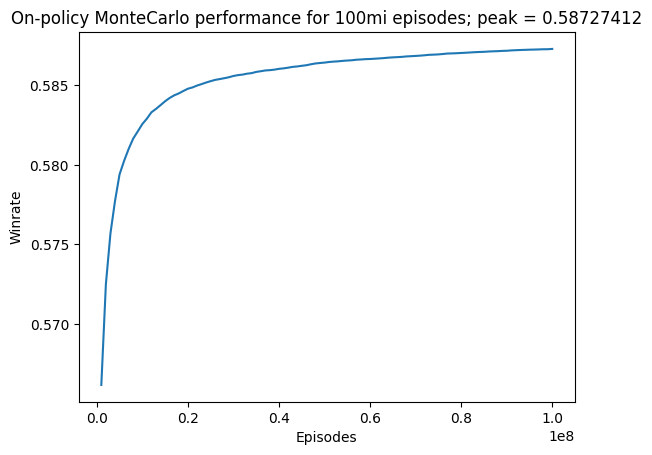

In [29]:
x = [i * million for i in range(1,episodes_mil+1)]
y = mc_on_policy_agent.stats["winrate"]

plt.plot(x, y)
plt.xlabel("Episodes")
plt.ylabel("Winrate")
plt.title(f"On-policy MonteCarlo performance for 100mi episodes; peak = {max(y)}")
plt.show()

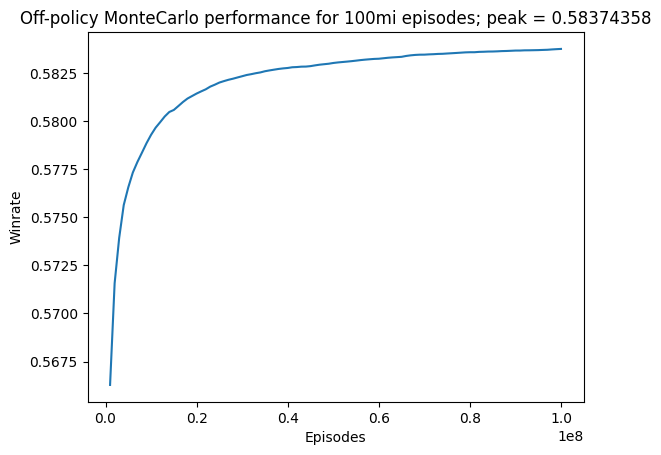

In [28]:
y = mc_off_policy_agent.stats["winrate"]

plt.plot(x, y)
plt.xlabel("Episodes")
plt.ylabel("Winrate")
plt.title(f"Off-policy MonteCarlo performance for 100mi episodes; peak = {max(y)}")
plt.show()